In [125]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (15,10)})

# import helper functions
from src.utls import compute_repeated_stats

In [126]:
# (import) helper functions
dir_proj = Path("__file__").absolute().parents[1]
dir_rawdata = Path.joinpath(dir_proj, "data")
dir_prep = Path.joinpath(dir_proj,"results")
print(dir_rawdata)


c:\Users\User\Desktop\kiel\tremor_music_ap\data


In [127]:
# load data
pd.read_csv(Path.joinpath(dir_prep,"single_subj_pow.csv"))
peaks = pd.read_csv(Path.joinpath(dir_prep,"single_subj_agg.csv"))
group_asgn = pd.read_excel(Path.joinpath(dir_rawdata,"group_assign.xlsx"), index_col=None)

In [128]:
# define cfg vars
cfg_srate = 100
cfg_group = {1:"Standard & exp. music", 2:"Standard & unspecific music", 3: "Only Standard", 4: "Placebo"}
cfg_trial = {1: "Standing flexed", 2:"Sitting", 3: "Sitting relaxed"}
cfg_visit = {1:"Inital", 2:"14-days"}

idx_axis_oi = peaks["axis"] == "y"
idx_task_oi = peaks["task"] == "Sitting flexed"
idx_visit_oi = peaks["visit"] != "Follow-up"


In [129]:
# assign group
group = pd.melt(group_asgn, value_name="id").dropna()
group["id"] = group["id"].str.replace(' ','')
peaks_group = pd.merge(peaks, group, on="id", how="outer")
peaks_group = peaks_group.rename(columns={"variable": "group"})

idx_visit_oi = peaks_group["visit"] != "Follow-up"
data_oi = peaks_group[idx_visit_oi]
data_oi = data_oi.groupby('id').filter(lambda x: {"Inital","14-days"}.issubset(x['visit']))
data_oi = data_oi.rename(columns={"variable": "group"})
sumed_axis = data_oi.groupby(['id','visit','group','task'],as_index=False)[["peak amplitude","peak frequency"]].sum()

n_rows = sumed_axis.shape[0]
sumed_axis["Norm amp"] = np.nan
sumed_axis["Norm freq"] = np.nan

# normalise per task

nms_tasks = sumed_axis["task"].unique()
for nm_t in nms_tasks:

    idx_task = sumed_axis["task"] == nm_t

    for i in range(0,n_rows):
        idx_id = sumed_axis["id"].str.match(sumed_axis["id"][i])
        sumed_axis["Norm amp"][i] = sumed_axis["peak amplitude"][i] / np.nanmax(sumed_axis["peak amplitude"][np.logical_and(idx_id, idx_task)])
        
sumed_axis.to_csv(Path.joinpath(dir_prep,"group_anova.csv"), index=False)

In [130]:
t_amp,p_amp, t_freq, p_freq = compute_repeated_stats(peaks,"Sitting relaxed")
print(f"p-value for amp is {p_amp:.3f}; p-value for freq is {p_freq:.3f};")

p-value for amp is 0.118; p-value for freq is 0.798;


## rmANOVA split for task

In [131]:
from statsmodels.stats.anova import AnovaRM

dat_sit_relx = sumed_axis[sumed_axis["task"] == "Sitting relaxed"]


In [132]:
#check if groups are balanced for statsmodel
dat_sit_relx.groupby(["visit","group"])["id"].count()

visit    group             
14-days  CONTROL GROUP 1       10
         CONTROL GROUP 2       10
         EXPERIMENTAL GROUP    10
         PLACEBO GROUP         12
Inital   CONTROL GROUP 1       10
         CONTROL GROUP 2       10
         EXPERIMENTAL GROUP    10
         PLACEBO GROUP         12
Name: id, dtype: int64

In [133]:
dat_rmanova = dat_sit_relx[["id","visit","Norm amp"]].copy()

aovrm1way = AnovaRM(dat_rmanova, 'Norm amp', 'id', within=['visit'], aggregate_func='mean')
res1way = aovrm1way.fit()

print(res1way)

n = dat_rmanova["id"].nunique()
print(f"A one-way repeated measures ANOVA was conducted on {n:2d} individuals to examine the effect of music therapy on tremor amplitude.")
print(f"Results showed that the treatment of therapy lead to statistically significant differences in tremor amplitude (F(1, {n-1:2d}) = 6.29, p = 0.0162")

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
visit  0.1377 1.0000 41.0000 0.7125

A one-way repeated measures ANOVA was conducted on 42 individuals to examine the effect of music therapy on tremor amplitude.
Results showed that the treatment of therapy lead to statistically significant differences in tremor amplitude (F(1, 41) = 6.29, p = 0.0162


### Check ANOVA assumptions

In [134]:
# Bartletts test for normal distribution

from bioinfokit.analys import stat 
res = stat()
res.bartlett(df=dat_sit_relx, res_var='peak amplitude', xfac_var='group')
res.bartlett_summary

print(f"For the Bartletts test the p-value is 0.070")
print(f"As the p value is non significant, we conclude that data is drawn from normal distribution.")

ValueError: Must enter at least two input sample vectors.

(0.0, 20.0)

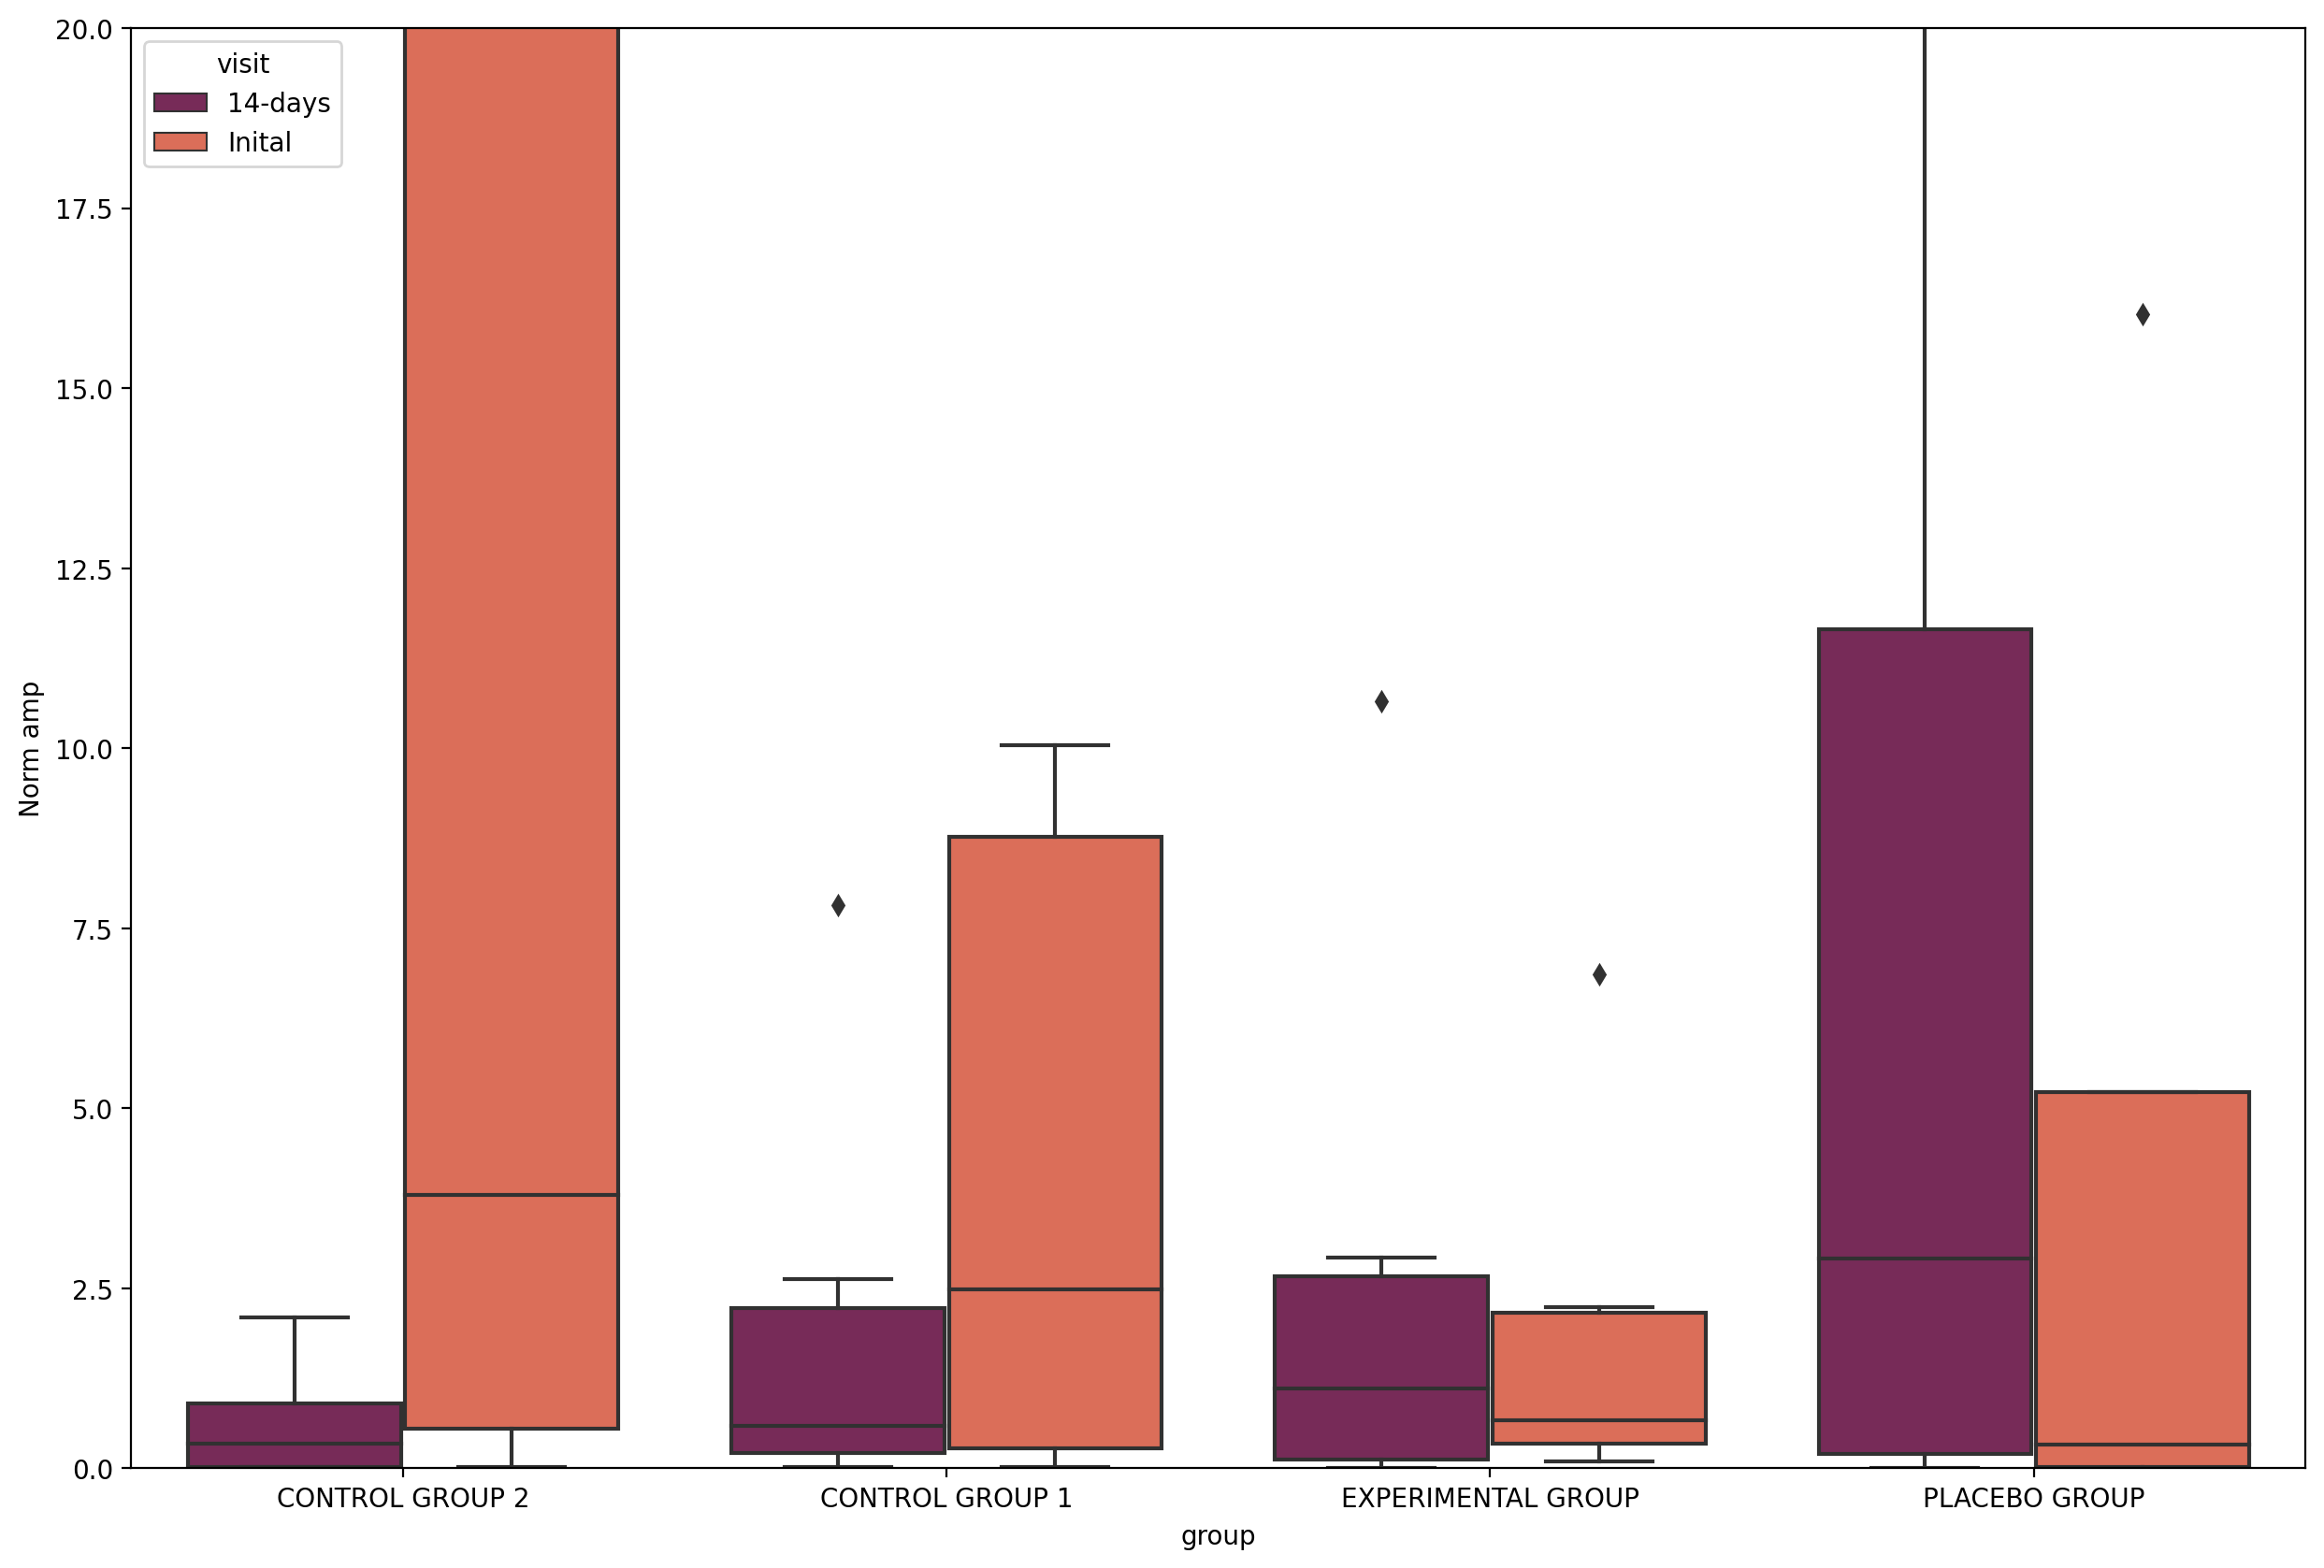

In [140]:
sns.boxplot(x="group", y="Norm amp", hue="visit", data=dat_sit_relx, palette="rocket") 
plt.ylim([0,20])

In [137]:
dat_rmanova = dat_sit_relx[["id","group","visit","Norm amp"]].copy()
dat_rmanova = dat_rmanova.rename(columns={"Norm amp": "amp"})

# rmANOVA table using bioinfokit v1.0.3 
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=dat_rmanova, res_var='amp', anova_model='amp~C(group)+C(visit)+C(group):C(visit)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(group),3.0,1.417580e+05,47252.666001,0.467684,0.705689
C(visit),1.0,1.255094e+04,12550.942266,0.124223,0.725474
C(group):C(visit),3.0,2.107280e+05,70242.678651,0.695229,0.557799
Residual,76.0,7.678688e+06,101035.364942,NaN,NaN


In [139]:
from scipy.stats import ttest_rel

exp_pre = dat_sit_relx["Norm amp"][np.logical_and(dat_sit_relx["group"] == "EXPERIMENTAL GROUP", dat_sit_relx["visit"] == "Inital")]
exp_post = dat_sit_relx["Norm amp"][np.logical_and(dat_sit_relx["group"] == "EXPERIMENTAL GROUP", dat_sit_relx["visit"] == "14-days")]
# Run independent samples t-test
t_val, p_val = ttest_rel(exp_pre, exp_post)
# Check the results of the t-test
print(f'T-Test comparison o pre & post:')
print(f'\tT-value \t {t_val:1.4f}')
print(f'\tP-value \t {p_val:1.2e}')

plac_pre = dat_sit_relx["Norm amp"][np.logical_and(dat_sit_relx["group"] == "PLACEBO GROUP", dat_sit_relx["visit"] == "Inital")]
plac_post = dat_sit_relx["Norm amp"][np.logical_and(dat_sit_relx["group"] == "PLACEBO GROUP", dat_sit_relx["visit"] == "14-days")]
# Run independent samples t-test
t_val, p_val = ttest_rel(plac_pre, plac_post)
# Check the results of the t-test
print(f'T-Test comparison o pre & post:')
print(f'\tT-value \t {t_val:1.4f}')
print(f'\tP-value \t {p_val:1.2e}')

T-Test comparison o pre & post:
	T-value 	 0.7903
	P-value 	 4.50e-01
T-Test comparison o pre & post:
	T-value 	 -0.8702
	P-value 	 4.03e-01
